In [1]:
import scipy as scp
import scipy.sparse
import scipy.sparse.linalg
from scipy.linalg import expm
from scipy.sparse import csr_array

from scipy.integrate import solve_ivp
from scipy.optimize import fmin
import matplotlib.pyplot as plt
import numpy as np

import functools # for functools.reduce
from tqdm import tqdm
import os

# Tools


In [2]:
def exp_mat(M) :
    '''
    Computes the matrix exponential exp(M)
    
    Parameters
    ----------
    M : csr_array
        matrix

    Return
    ------
    exp(M) : csr_array
    '''
    return scp.sparse.csr_array(expm(M.toarray()))

# Spin operators


In [3]:
sx = 1/2 * scipy.sparse.csr_array([[0.,  1.],[1., 0.]])
sy = 1/2 * scipy.sparse.csr_array([[0., -1.j],[1.j, 0.]])
sz = 1/2 * scipy.sparse.csr_array([[1., 0.],[0., -1.]])

I = scipy.sparse.identity(2)

sp = ((sx + 1.j * sy) / 2).real
sm = ((sx - 1.j * sy) / 2).real

$$
\hat{\sigma}^{z}_{j} = \underbrace{\hat{I}\otimes\hat{I}\dots\hat{I}}_{j-1\ \mathrm{terms}}\otimes\hat{\sigma}^{z}\otimes\underbrace{\hat{I}\otimes\hat{I}\dots\otimes\hat{I}}_{N-j\ \mathrm{terms}},
$$


In [4]:
def sx_j(j, N):
    """
    Compute the operator $X_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $X_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sx] + [I] * (N - j))


def sy_j(j, N):
    """
    Compute the operator $Y_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $Y_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sy] + [I] * (N - j))


def sz_j(j, N):
    """
    Compute the operator $Z_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $Z_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sz] + [I] * (N - j))


def sp_j(j, N):
    """
    Compute the operator $S^+_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $S^+_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sp] + [I] * (N - j))


def sm_j(j, N):
    """
    Compute the operator $S^-_j$ acting on a N-spin system.
    
    Parameters
    ----------
    j : int
        The index of the spin to act on.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The operator $S^-_j$.
    """
    return functools.reduce(scipy.sparse.kron, [I] * (j - 1) + [sm] + [I] * (N - j))


def write_spin_operators(N) :
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    os.makedirs(path, exist_ok=True)
    for k in range(1, N+1) :
        s = sx_j(k, N)
        scp.sparse.save_npz(path + f'/sx_k_{k}', s)

        s = sy_j(k, N)
        scp.sparse.save_npz(path + f'/sy_k_{k}', s)

        s = sz_j(k, N)
        scp.sparse.save_npz(path + f'/sz_k_{k}', s)

        s = sp_j(k, N)
        scp.sparse.save_npz(path + f'/sp_k_{k}', s)

        s = sm_j(k, N)
        scp.sparse.save_npz(path + f'/sm_k_{k}', s)


N = 8
write_spin_operators(N)


# Hamiltonian


In [5]:
def H_spin(N, J):
    """
    Compute the Hamiltonian of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    N : int
        The number of spins in the system.
    J : float
        The coupling constant.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Hamiltonian of the system.
    """
    H = 0

    for i in range(1, N+1):
        if i == N:
            ip1 = 1
        else:
            ip1 = i + 1
        H += J * (sx_j(i, N) @ sx_j(ip1, N) + sy_j(i, N) @ sy_j(ip1, N) + sz_j(i, N) @ sz_j(ip1, N))

    return H

N = 2
J= 1

H = H_spin(N, J)
H.toarray()

array([[ 0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -0.5+0.j,  1. +0.j,  0. +0.j],
       [ 0. +0.j,  1. +0.j, -0.5+0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j]])

# Lindbladian


Lindblad operators for the 2nd dissipator:


In [6]:
def get_Lks(N) :
    """
    Compute the L_k operators for a N-spin system (2nd dissipator).

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    list of scipy.sparse.csr_matrix
        The L_k operators.

    Note
    ----
    The L_k operators are indexed from 1 to N: get_Lks(N)[k] corresponds to L_k,
    and get_Lks(N)[0] is a dummy value to have the same indexing as in the paper.
    """

    Lks = [None]   # in order to have the same indexing as in the paper: from 1 to N

    for k in tqdm(range(1, N+1)) :
        kp1 = (k + 1) % N
        kp2 = (k + 2) % N

        if kp1 == 0:
            kp1 = N
        if kp2 == 0:
            kp2 = N

        sp_k = sp_j(k, N)
        sm_kp1 = sm_j(kp1, N)
        sp_kp2 = sp_j(kp2, N)

        Lk = 1/2 * (sp_k @ sm_kp1 + 1j * sm_kp1 @ sp_kp2)
        Lks.append(Lk)

    return Lks



def write_Lk_operators(N) :
    path = f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}'
    for k in tqdm(range(1, N+1)) :
        kp1 = (k + 1) % N
        kp2 = (k + 2) % N

        if kp1 == 0:
            kp1 = N
        if kp2 == 0:
            kp2 = N

        sp_k = scp.sparse.load_npz(path + f'/sp_k_{k}.npz')
        sm_kp1 = scp.sparse.load_npz(path + f'/sm_k_{kp1}.npz')
        sp_kp2 = scp.sparse.load_npz(path + f'/sp_k_{kp2}.npz')

        Lk = 1/2 * (sp_k @ sm_kp1 + 1j * sm_kp1 @ sp_kp2)
        scp.sparse.save_npz(path + f'/Lk_{k}', Lk)



N = 2
write_Lk_operators(N)
# Lks = get_Lks(N)
# Lks


100%|██████████| 2/2 [00:00<00:00, 86.94it/s]


In [7]:
# TODO
# check new Lk does not change the results
# adapt dissipators: instead of computing, fetch operators
# adapt Ob, Jh
# adapt initial set up
# add check up in initial setup: if operators already computed, do not compute again

In [47]:
# write all operators

N = 14
write_spin_operators(N) # 10 min for N=14

In [48]:
write_Lk_operators(N) # 1h30 for N=14, already done from 1 to 5

 36%|███▌      | 5/14 [34:14<59:20, 395.63s/it]  

In [8]:
N = 8
write_Lk_operators(N)
Lks = get_Lks(N)

100%|██████████| 8/8 [00:00<00:00, 115.86it/s]


In [9]:
for k in range(1, N+1) :
    Lk = scp.sparse.load_npz(f'results/time_dependent_GGE/heisenberg_spins/operators/N_{N}/Lk_{k}.npz')
    assert scp.sparse.linalg.norm(Lk - Lks[k]) == 0

Dissipators:


In [8]:
def dissipator_1(rho, J, N) :
    """
    Compute the 1st dissipator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The 1st dissipator of the system.
    """
    D = 0
    for k in range(1, N+1) :
        D += J * (sz_j(k, N) @ rho @ sz_j(k, N) - 0.5 * (sz_j(k, N) @ sz_j(k, N) @ rho + rho @ sz_j(k, N) @ sz_j(k, N)))
    return D

def dissipator_2(rho, J, N) :
    """
    Compute the 2nd dissipator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The 2nd dissipator of the system.
    """
    D = 0
    for k in range(1, N+1) :
        D += J * (Lks[k] @ rho @ Lks[k].H - 0.5 * (Lks[k].H @ Lks[k] @ rho + rho @ Lks[k].H @ Lks[k]))
    return D

rho_test = scipy.sparse.identity(2**N)
dissipator_1(rho_test, J, N), dissipator_2(rho_test, J, N)


NameError: name 'Lks' is not defined

Lindbladian


In [9]:
def lindblad_non_unitary(rho, epsilon, gamma, J, N) :
    """
    Compute the non-unitary part of the Lindblad equation of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The non-unitary part of the Lindbladian of the system.
    """
    L1 = epsilon * (gamma * dissipator_1(rho, J, N) + (1 - gamma) * dissipator_2(rho, J, N))
    return L1 


def lindblad(rho, H, epsilon, gamma, J, N) :
    """
    Compute the Lindblad equation of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix of the system.
    H : scipy.sparse.csr_matrix
        The Hamiltonian of the system.
    epsilon : float
        The perturbation strength.
    gamma : float
        The relative strength.
    J : float
        The coupling constant.
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Lindbladian of the system.
    """
    L0 = - 1j * (H @ rho - rho @ H)
    L1 = lindblad_non_unitary(rho, epsilon, gamma, J, N)
    return L0 + L1 


EPSILON = 0.1
GAMMA = 0.5
lindblad(rho_test, H_spin(N, J), EPSILON, GAMMA, J, N)

NameError: name 'Lks' is not defined

# Quantities useful to define Conserved quantities


In [10]:
def Ob(N) :
    """
    Boost operator

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The boost operator.
    """
    O = 0

    for i in range(1, N+1):
        if i == N:
            ip1 = 1
        else:
            ip1 = i + 1
        O += -1j * i * (sx_j(i, N) @ sx_j(ip1, N) + sy_j(i, N) @ sy_j(ip1, N) + sz_j(i, N) @ sz_j(ip1, N))
        
    return O

Ob(N)

<4x4 sparse matrix of type '<class 'numpy.complex128'>'
	with 16 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [11]:
def Jh(N, J) :
    """
    Compute the heat current operator of an N-spin system with nearest-neighbor interactions.

    Parameters
    ----------
    N : int
        The number of spins in the system.
    J : float
        The coupling constant.

    Returns
    -------
    float
        The value of the JH operator.
    """
    JH = 0

    for k in range(1, N+1) :
        kp1 = (k + 1) % N
        kp2 = (k + 2) % N

        if kp1 == 0:
            kp1 = N
        if kp2 == 0:
            kp2 = N

        S_k = sx_j(k, N), sy_j(k, N), sz_j(k, N)
        S_kp1 = sx_j(kp1, N), sy_j(kp1, N), sz_j(kp1, N)
        S_kp2 = sx_j(kp2, N), sy_j(kp2, N), sz_j(kp2, N)

        # just to make the formula of the cross product more readable
        u = S_k
        v = S_kp1
        S_cross = [
            u[1] @ v[2] - u[2] @ v[1], 
            u[2] @ v[0] - u[0] @ v[2], 
            u[0] @ v[1] - u[1] @ v[0],
        ]
        JH += J**2 * (S_cross[0] @ S_kp2[0] + S_cross[1] @ S_kp2[1] + S_cross[2] @ S_kp2[2])
    
    return JH
    
Jh(N, J)

<4x4 sparse matrix of type '<class 'numpy.complex128'>'
	with 16 stored elements (blocksize = 2x2) in Block Sparse Row format>

In [12]:
N = 2
J = 1
EPSILON = 0.1
GAMMA = 0.5

Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    # C4,
    # C5
]

In [12]:
# Hyperparameters
N = 8
J = 1
EPSILON = 0.1
GAMMA = 0.8
Lks = get_Lks(N)

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]

100%|██████████| 8/8 [00:00<00:00, 85.47it/s]


# GGE


In [13]:
def GGE(lagr, conserved_quantities) :
    """
    Compute the Generalized Gibbs Ensemble (GGE) density matrix, given the Lagrange multipliers and the conserved quantities.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    scipy.sparse.csr_matrix
        The GGE density matrix.
    """    
    exponent = 0
    for lambda_i, C_i in zip(lagr, conserved_quantities) :
        exponent -= lambda_i * C_i

    U = exp_mat(exponent)
    rho = U / scp.sparse.csr_matrix.trace(U)
    return rho

test_GGE = GGE([1, 1, 1, 1], Cs); test_GGE

<256x256 sparse array of type '<class 'numpy.complex128'>'
	with 12870 stored elements in Compressed Sparse Row format>

In [14]:
def avg_GGE(lagr, conserved_quantities, O) :
    """
    Compute the average of an observable in the Generalized Gibbs Ensemble (GGE), given the Lagrange multipliers, the conserved quantities, and the observable.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    O : scipy.sparse.csr_matrix
        The observable.

    Returns
    -------
    float
        The average of the observable in the GGE.
    """
    rho = GGE(lagr, conserved_quantities)
    return scp.sparse.csr_matrix.trace(rho @ O)

avg_GGE([1] * len(Cs), Cs, sp_j(1, N))

0j

# EOM Lagrange multipliers


In [15]:
def chi(lagr, conserved_quantities) :
    """
    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    O : scipy.sparse.csr_matrix
        The observable.

    Returns
    -------
    float
        The susceptibility of the observable in the GGE.
    """
    n = len(conserved_quantities)
    chi_mat = np.zeros((n, n))
    for i in range(n) :
        for j in range(n) :
            chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \
                            - avg_GGE(lagr, conserved_quantities, conserved_quantities[i]) * avg_GGE(lagr, conserved_quantities, conserved_quantities[j])
    return chi_mat
    

def force(lagr, conserved_quantities) :
    """
    Compute the force acting on the Lagrange multipliers, given the Lagrange multipliers, the conserved quantities.

    Parameters
    ----------
    lagr : list of float
        The Lagrange multipliers.

    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    list of float
        The force acting on the Lagrange multipliers.
    """
    rho_GGE = GGE(lagr, conserved_quantities)

    n = len(conserved_quantities)
    vect = np.zeros(n)
    for j in range(n) :
        vect[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ lindblad_non_unitary(rho_GGE, EPSILON, GAMMA, J, N))

    chi_mat = chi(lagr, conserved_quantities)
    chi_mat_inv = np.linalg.inv(chi_mat)

    f = -chi_mat_inv @ vect
    return f


display(chi([0]*len(Cs), Cs))

force([0]*len(Cs), Cs)

C:\Users\antho\AppData\Local\Temp\ipykernel_17456\2995203031.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


array([[  1.5   ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.75  ,   0.    , -11.625 ],
       [  0.    ,   0.    ,  11.625 ,   0.    ],
       [  0.    , -11.625 ,   0.    , 663.1875]])

C:\Users\antho\AppData\Local\Temp\ipykernel_17456\2995203031.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  vect[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ lindblad_non_unitary(rho_GGE, EPSILON, GAMMA, J, N))


array([0.        , 0.00041667, 0.        , 0.        ])

# Néel configuration


up, down, up, down, ...


In [16]:
def generate_neel(N) :
    """
    Generate the Neel state for a N-spin system.

    Parameters
    ----------
    N : int
        The number of spins in the system.

    Returns
    -------
    scipy.sparse.csr_matrix
        The Neel state.
    """
    up = np.array([1, 0])
    down = np.array([0, 1])

    state = 1

    # starts with up
    for i in range(1, N+1) :
        if i % 2 == 1 :
            state = np.kron(state, up)
        else :
            state = np.kron(state, down)

    rho = scp.sparse.csr_matrix(state).T @ scp.sparse.csr_matrix(state)
    return rho

N = 8
GGE_neel = generate_neel(8).toarray(); display(GGE_neel)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

array([ 1.58283761e+00, -3.51419571e-05,  6.02500328e-06, -9.55266726e-07])

'Total Spin Sz: 0j'

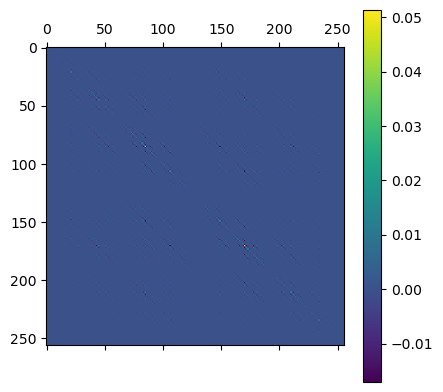

In [18]:
def find_lagr_closest_GGE(rho, conserved_quantities) :
    """
    Find the closest GGE density matrix to the Neel state, given the Lagrange multipliers and the conserved quantities.

    Parameters
    ----------
    rho : scipy.sparse.csr_matrix
        The density matrix to be written in the GGE formalism.
    lagr : list of float
        The Lagrange multipliers.
    conserved_quantities : list of scipy.sparse.csr_matrix
        The conserved quantities.

    Returns
    -------
    scipy.sparse.csr_matrix
        The closest GGE density matrix to the Neel state.
    """

    solution = fmin(lambda x: np.linalg.norm(GGE(x, conserved_quantities).toarray() - rho), x0=np.zeros(len(conserved_quantities)), disp=False)
    return solution

GGE_neel = generate_neel(N)
lambdas_GGE_neel = find_lagr_closest_GGE(GGE_neel, Cs); display(lambdas_GGE_neel)

total_spin = 0
for j in range(1, N+1) :
    total_spin += avg_GGE(lambdas_GGE_neel, Cs, sp_j(j, N))
display(f"Total Spin Sz: {total_spin}")

plt.matshow(GGE(lambdas_GGE_neel, Cs).toarray().real)
plt.colorbar()
plt.savefig('results/time_dependent_GGE/heisenberg_spins/GGE_neel.png')

# Numerical integration


In [20]:
# Hyperparameters
N = 8
J = 1
EPSILON = 0.1
GAMMA = 0.8
Lks = get_Lks(N)

# Conserved quantities
Ob_val = Ob(N)

C2 = H_spin(N, J)
C3 = Jh(N, J)                   # JH
C4 = Ob_val @ C3 - C3 @ Ob_val  # [Ob, C3]
C5 = Ob_val @ C4 - C4 @ Ob_val  # [Ob, C4]

Cs = [
    C2,
    C3,
    C4,
    C5
]

# Initial conditions
GGE_neel = generate_neel(N)
lambdas_0 = find_lagr_closest_GGE(GGE_neel, Cs)
np.savetxt(f"lambdas_0_N_{N}.txt", lambdas_0)

# Time grid
# t_eval = np.arange(0, np.pi, 0.1)
tmin = 0
tmax = 90
t_eval = np.linspace(tmin, tmax, 100)


  0%|          | 0/14 [00:00<?, ?it/s]

Compute


In [ ]:
F = lambda t, s: force(s, Cs)

sol = solve_ivp(F, [tmin, tmax], lambdas_0, t_eval=t_eval)

all_params = np.vstack([sol.t, sol.y]).T
np.savetxt("results/time_dependent_GGE/heisenberg_spins/first_try/time_dependent_params.txt", all_params)

C:\Users\antho\AppData\Local\Temp\ipykernel_10196\2995203031.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  vect[j] = scp.sparse.csr_matrix.trace(conserved_quantities[j] @ lindblad_non_unitary(rho_GGE, EPSILON, GAMMA, J, N))
C:\Users\antho\AppData\Local\Temp\ipykernel_10196\2995203031.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  chi_mat[i, j] = avg_GGE(lagr, conserved_quantities, conserved_quantities[i] @ conserved_quantities[j]) \


# Plot observables


In [ ]:
Y = []
time_dependent_params = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/time_dependent_params.txt", unpack=True)
t_eval = time_dependent_params[0]
lagr = time_dependent_params[1:]


Compute


In [ ]:
# Heat current
for i, t in enumerate(t_eval) :
    avg_current = avg_GGE(lagr.T[i], Cs, -Jh(N, J)) / N
    Y.append(avg_current)

np.savetxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", np.vstack([t_eval, np.array(Y)]).T.real)


Plot


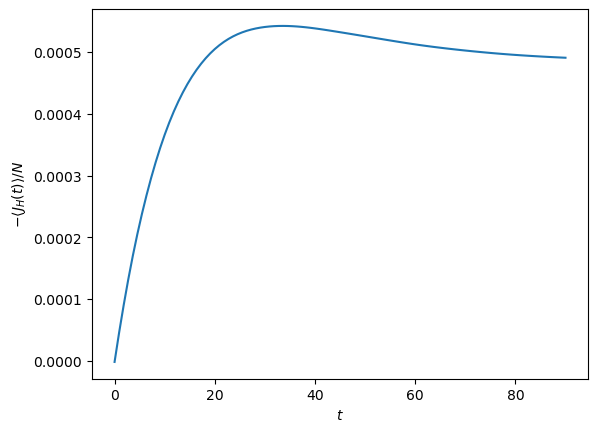

In [ ]:
t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", unpack=True)

plt.plot(t_eval, Y)
plt.xlabel(r'$t$')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 
plt.savefig("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.pdf")

## to do: plot avg spin correlation


In [26]:
Y = []
time_dependent_params = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/time_dependent_params.txt", unpack=True)
t_eval = time_dependent_params[0]
lagr = time_dependent_params[1:]


Compute


In [ ]:
# 
for i, t in enumerate(t_eval) :
    avg_current = avg_GGE(lagr.T[i], Cs, ) 
    Y.append(avg_current)

np.savetxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", np.vstack([t_eval, np.array(Y)]).T.real)


Plot


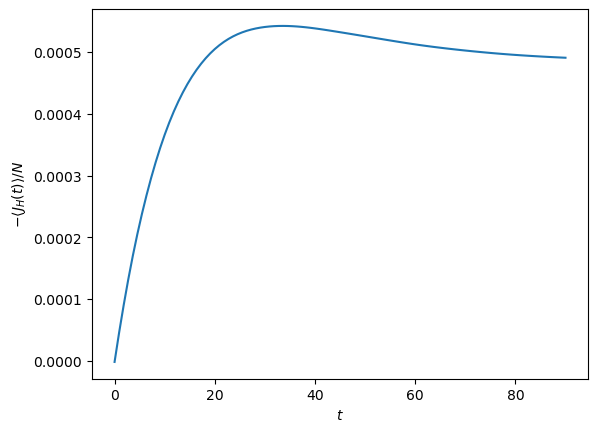

In [ ]:
t_eval, Y = np.loadtxt("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.txt", unpack=True)

plt.plot(t_eval, Y)
plt.xlabel(r'$t$')
plt.ylabel(r'$-\left< J_H(t) \right> / N$') 
plt.savefig("results/time_dependent_GGE/heisenberg_spins/first_try/avg_current.pdf")